In [1]:
import matplotlib.pyplot as plt
from matminer.datasets import load_dataset
from pymatgen.symmetry.groups import SpaceGroup
from pymatviz import (
    annotate_bars,
    plot_structure_2d,
    ptable_heatmap,
    spacegroup_sunburst,
)
from tqdm import tqdm


plt.rc("font", size=14)
plt.rc("savefig", bbox="tight", dpi=200)
plt.rc("axes", titlesize=16, titleweight="bold")
plt.rcParams["figure.constrained_layout.use"] = True

In [2]:
df_perov = load_dataset("matbench_perovskites")

df_perov[["spg_symbol", "spg_num"]] = [
    struct.get_space_group_info() for struct in tqdm(df_perov.structure)
]
df_perov["volume"] = df_perov.structure.map(lambda struct: struct.volume)

df_perov["formula"] = df_perov.structure.map(lambda cryst: cryst.formula)

df_perov["crys_sys"] = df_perov.spg_symbol.map(
    lambda spg: SpaceGroup(spg).crystal_system
)

100%|██████████| 18928/18928 [00:08<00:00, 2362.47it/s]


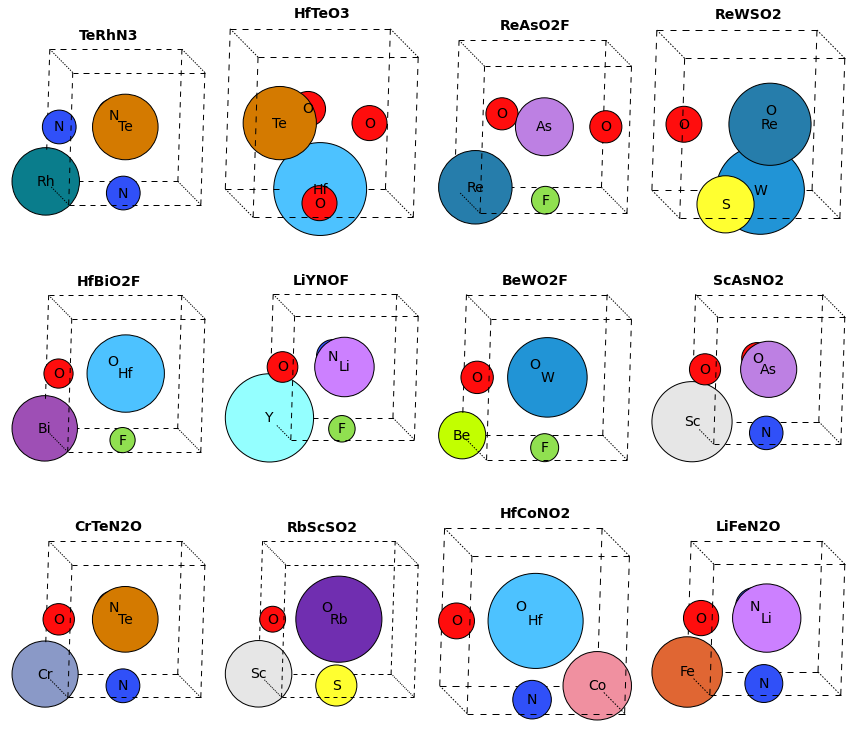

In [3]:
fig, axs = plt.subplots(3, 4, figsize=(12, 12))

for struct, ax in zip(df_perov.structure.head(12), axs.flat):
    ax = plot_structure_2d(struct, ax=ax)
    ax.set_title(struct.composition.reduced_formula, fontsize=14)

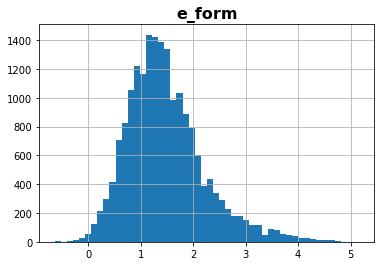

In [4]:
df_perov.hist(column="e_form", bins=50)

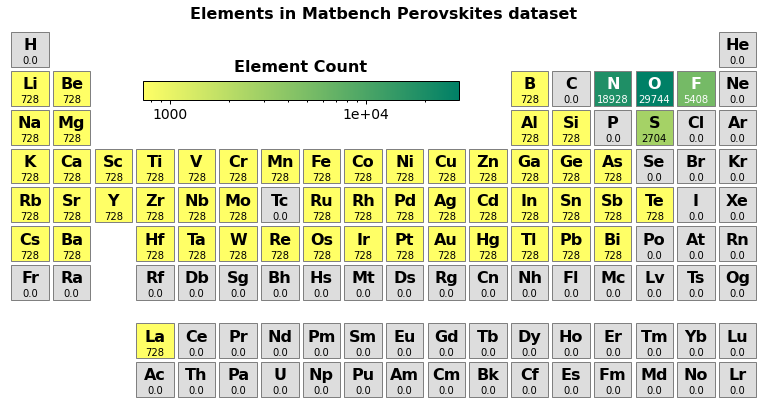

In [5]:
ax = ptable_heatmap(df_perov.formula, log=True)
plt.title("Elements in Matbench Perovskites dataset")
plt.savefig("perovskites-ptable-heatmap.pdf")



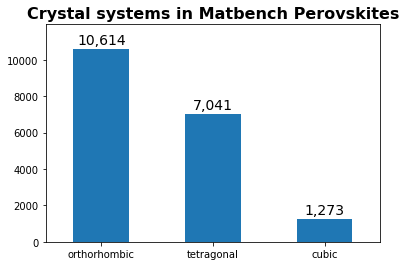

In [6]:
df_perov["crys_sys"].value_counts().plot.bar()

plt.title("Crystal systems in Matbench Perovskites")
plt.xticks(rotation="horizontal")

annotate_bars(v_offset=250)

<AxesSubplot:xlabel='volume', ylabel='e_form'>

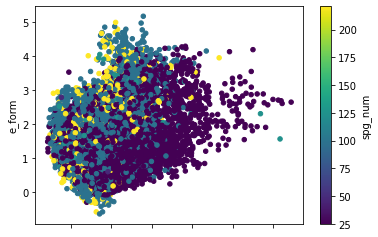

In [7]:
df_perov.plot.scatter(x="volume", y="e_form", c="spg_num", colormap="viridis")

In [8]:
fig = spacegroup_sunburst(df_perov.spg_num, show_values="percent")
fig.update_layout(title="Matbench Perovskites spacegroup sunburst")

/Users/janosh/.venv/py310/lib/python3.10/site-packages/plotly/express/_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
/Users/janosh/.venv/py310/lib/python3.10/site-packages/plotly/express/_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
